In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on Meshes
This notebook shows how define and evaluate kernels on a simple mesh.

Inside, we use [potpourri3d](https://github.com/nmwsharp/potpourri3d) and [robust_laplacian](https://github.com/nmwsharp/robust-laplacians-py) to work with meshes.

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Mesh
from geometric_kernels.kernels import MaternGeometricKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots

INFO: Using numpy backend


## Defining a Space

First, we create a GeometricKernels space that corresponds to a teddy bear mesh loaded from "../data/teddy.obj"

In [3]:
mesh = Mesh.load_mesh(str(Path.cwd() / "data" / "teddy.obj"))
print("Number of vertices in the mesh:", mesh.num_vertices)

Number of vertices in the mesh: 1598


We define mesh plotting utils for `plotly`

In [4]:
def update_figure(fig):
    """Utility to clean up figure"""
    fig.update_layout(scene_aspectmode="cube")
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
    # fig.update_traces(showscale=False, hoverinfo="none")
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

    fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)")
    fig.update_layout(
        scene=dict(
            xaxis=dict(showbackground=False, showticklabels=False, visible=False),
            yaxis=dict(showbackground=False, showticklabels=False, visible=False),
            zaxis=dict(showbackground=False, showticklabels=False, visible=False),
        )
    )
    return fig

def plot_mesh(mesh: Mesh, vertices_colors = None, **kwargs):
    plot = go.Mesh3d(
        x=mesh.vertices[:, 0],
        y=mesh.vertices[:, 1],
        z=mesh.vertices[:, 2],
        i=mesh.faces[:, 0],
        j=mesh.faces[:, 1],
        k=mesh.faces[:, 2],
        colorscale='viridis',
        intensity=vertices_colors,
        **kwargs
    )
    return plot

Now we actually visualize the mesh.

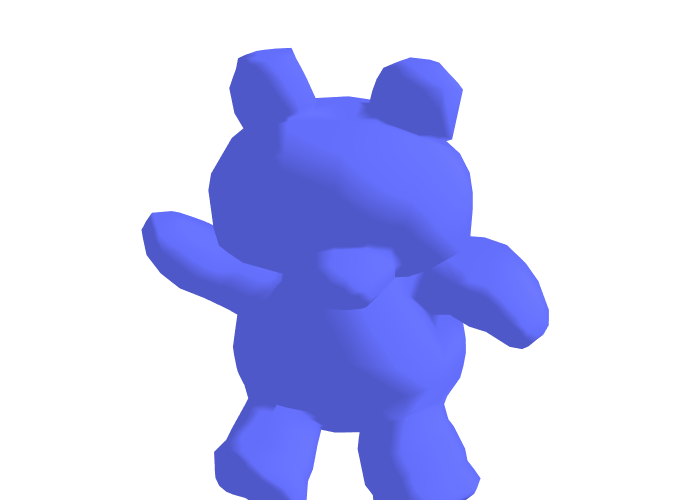

In [5]:
# Define the camera
camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0.7, z=1.25)
)

plot = plot_mesh(mesh)
fig = go.Figure(plot)
update_figure(fig)
fig.update_layout(
    scene_camera=camera
)
fig.show('png')

## Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `mesh` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on graphs can be found on this [documentation page](https://gpflow.github.io/GeometricKernels/theory/mesh.html).

In [6]:
kernel = MaternGeometricKernel(mesh)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [7]:
params = kernel.init_params()
print('params:', params)

params: {'lengthscale': array(1.), 'nu': array(inf)}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [8]:
params["lengthscale"] = np.array([2.0])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` (uniformly) random points on our mesh.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [9]:
key = np.random.RandomState(1234)

key, xs = mesh.random(key, 10)

print(xs)

[[ 815]
 [ 723]
 [1318]
 [1077]
 [1228]
 [1396]
 [ 664]
 [ 689]
 [ 279]
 [1257]]


Now we evaluate the two kernel matrices.

In [10]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

/Users/vabor112/Workspace/GeometricKernels/venv/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:347: BeartypeDecorHintPep585DeprecationWarning:

PEP 484 type hint typing.List deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations



Finally, we visualize these matrices using `imshow`.

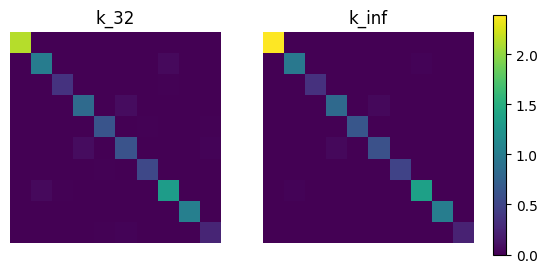

In [11]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

Here we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
We define `base_point` and `other_points` in the next cell.

In [12]:
base_point = 1 # choosing a fixed node for kernel visualization
other_points = np.arange(mesh.num_vertices)[:, None]

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [13]:
values_32  = kernel.K(params_32,  np.array([[base_point]]),
                              other_points).flatten()
values_inf = kernel.K(params_inf, np.array([[base_point]]),
                              other_points).flatten()

We also evaluate the variances $k_{\nu, \kappa}(x, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [14]:
# Get prior variances k(*, *) for * in nodes:
variance_32  = kernel.K_diag(params_32,  other_points)
variance_inf = kernel.K_diag(params_inf, other_points)

Here are the actual visualization routines.

**Note:** the top right plot shows `k(base_point, *)` where `*` goes through all nodes and `base_point` has red outline. 

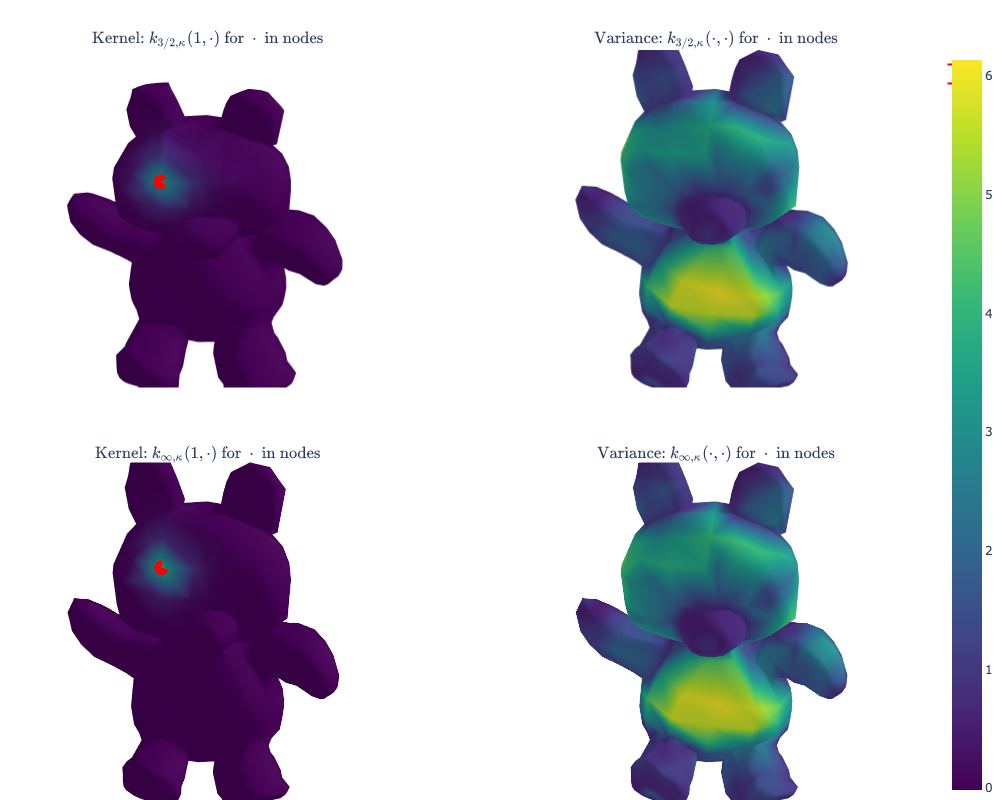

In [15]:
# Set the colorbar limits:
vmin = min(0.0, values_32.min(), values_inf.min())
vmax = max(1.0, variance_32.max(), variance_inf.max())
contours=dict(start=vmin, end=vmax)


# Marker for the base_point
base_point_plot  = go.Scatter3d(
    x=np.array([mesh.vertices[base_point][0]]),
    y=np.array([mesh.vertices[base_point][1]]),
    z=np.array([mesh.vertices[base_point][2]]),
    marker_color = 'red',
    name=''
)

# Various plots as plotly traces
values_32_plot     = plot_mesh(mesh, vertices_colors=values_32,    coloraxis = "coloraxis")
values_inf_plot    = plot_mesh(mesh, vertices_colors=values_inf,   coloraxis = "coloraxis")
variance_32_plot   = plot_mesh(mesh, vertices_colors=variance_32,  coloraxis = "coloraxis")
variance_inf_plot  = plot_mesh(mesh, vertices_colors=variance_inf, coloraxis = "coloraxis")

# Setting up the layout
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=(r"$\text{Kernel: }k_{3/2, \kappa}(1, \cdot)\text{ for }\cdot\text{ in nodes}$",
                    r"$\text{Variance: }k_{3/2, \kappa}(\cdot, \cdot)\text{ for }\cdot\text{ in nodes}$",
                    r"$\text{Kernel: }k_{\infty, \kappa}(1, \cdot)\text{ for }\cdot\text{ in nodes}$",
                    r"$\text{Variance: }k_{\infty, \kappa}(\cdot, \cdot)\text{ for }\cdot\text{ in nodes}$"),
    vertical_spacing=0.1)

# Adding the traces
fig.add_trace(base_point_plot,    row=1, col=1)
fig.add_trace(values_32_plot,     row=1, col=1)

fig.add_trace(base_point_plot,    row=2, col=1)
fig.add_trace(values_inf_plot,    row=2, col=1)

fig.add_trace(variance_32_plot,   row=1, col=2)

fig.add_trace(variance_inf_plot,  row=2, col=2)

fig = update_figure(fig)

fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera
fig.layout.scene4.camera = camera


fig.update_layout(
    margin={'t': 50},
    coloraxis = {'colorscale':'viridis'},
)

fig.show('png', width=1000, height=800)

# Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on meshes, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [16]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For graphs, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `Mesh` space, the first element is `None` since the feature map is *deterministic*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [17]:
# xs are random points from above
_, embedding = feature_map(xs, params_32)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (10, 1)):
[[ 815]
 [ 723]
 [1318]
 [1077]
 [1228]
 [1396]
 [ 664]
 [ 689]
 [ 279]
 [1257]]

emedding (shape = (10, 1000)):
[[-9.48138212e-02  8.75969355e-02 -9.14631992e-02 ...  1.07557661e-16
   2.98416165e-17 -3.04261209e-06]
 [-9.48138212e-02  8.99494490e-02  3.35192878e-03 ...  1.22838428e-16
  -1.61830284e-16 -1.87259715e-07]
 [-9.48138212e-02  8.47228039e-02  2.08692926e-02 ... -7.89989525e-16
   8.05734299e-16  2.34421988e-05]
 ...
 [-9.48138212e-02  8.37383742e-02  2.90949800e-02 ... -1.65122911e-16
  -4.88408840e-16  1.96659052e-07]
 [-9.48138212e-02 -9.29252086e-02 -1.45448646e-02 ...  3.29262586e-11
  -2.26376157e-10 -9.10860163e-11]
 [-9.48138212e-02  7.07017837e-03  8.21780655e-02 ...  1.66423744e-16
   5.96084445e-11 -7.57324398e-11]]

||k(xs, xs) - phi(xs) * phi(xs)^T|| = 7.649213087005109e-16


## Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [18]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[ 0.73537055 -1.58234598]
 [-1.07420008  0.09499642]
 [ 0.24709219  0.61271015]
 [ 0.16337301  1.08861213]
 [-1.11295791 -0.47629292]
 [-0.51964344 -0.92497923]
 [-0.42862706  1.26920139]
 [-2.54011101 -0.03172569]
 [-0.74658362 -1.52959816]
 [ 0.2368658  -0.16511647]]


### Visualizing Samples
Here we visualize samples as functions on a mesh.

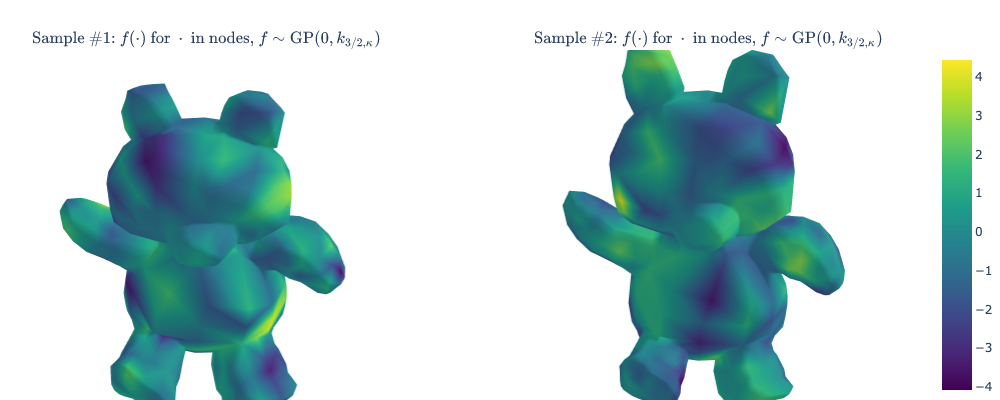

In [19]:
key = np.random.RandomState(seed=1234)
key, samples = sample_paths(other_points, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

# Set the colorbar limits:
vmin = min(sample1.min(), sample2.min())
vmax = max(sample1.max(), sample2.max())
contours=dict(start=vmin, end=vmax)

# Various plots as plotly traces
sample1_plot = plot_mesh(mesh, vertices_colors=sample1, coloraxis = "coloraxis")
sample2_plot = plot_mesh(mesh, vertices_colors=sample2, coloraxis = "coloraxis")

# Setting up the layout
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=(r"$\text{Sample #1: }f(\cdot)\text{ for }\cdot\text{ in nodes, }f \sim \mathrm{GP}(0, k_{3/2, \kappa})$",
                    r"$\text{Sample #2: }f(\cdot)\text{ for }\cdot\text{ in nodes, }f \sim \mathrm{GP}(0, k_{3/2, \kappa})$",
                   ),
)

# Adding the traces
fig.add_trace(sample1_plot, row=1, col=1)
fig.add_trace(sample2_plot, row=1, col=2)

fig = update_figure(fig)

fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera


fig.update_layout(
    margin={'t': 50},
    coloraxis = {'colorscale':'viridis'},
)

fig.show('png', width=1000, height=400)

# Citations

If you are using meshes and GeometricKernels, please consider citing

```
@article{borovitskiy2020,
    title={Matern Gaussian processes on Riemannian manifolds},
    author={Viacheslav Borovitskiy and Alexander Terenin and Peter Mostowsky and Marc Peter Deisenroth},
    booktitle={Advances in Neural Information Processing Systems},
    year={2020}}
```

```
@article{sharp2020,
  author={Nicholas Sharp and Keenan Crane},
  title={A Laplacian for Nonmanifold Triangle Meshes},
  journal={Computer Graphics Forum (SGP)},
  volume={39},
  number={5},
  year={2020}}
```